In [142]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [143]:
from collections import defaultdict, Counter
from copy import deepcopy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import missingno as msno

In [127]:
df_train = pd.read_csv('/content/train.csv')

df_test = pd.read_csv('/content/test.csv')

In [128]:
df_train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,...,pc_91,pc_92,pc_93,pc_94,pc_95,pc_96,pc_97,pc_98,pc_99,pc_100
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,...,20517.973164,23072.031367,25918.199746,29130.680234,32741.818105,36776.940391,41337.948828,46440.194570,52182.348633,58608.434023
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,...,4178.079326,4564.280930,4987.905991,5457.903966,5976.209199,6537.572468,7149.014724,7826.130471,8559.884813,9368.567796
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,...,20522.705605,23075.290605,25927.208926,29136.474492,32743.575156,36780.525273,41344.256875,46461.810508,52207.803164,58651.855859
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,...,20522.544570,23075.227422,25928.721426,29137.418496,32742.759414,36779.554531,41344.410508,46463.711484,52212.429531,58661.142344
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,...,4223.781546,4615.144614,5045.280631,5520.831567,6044.115860,6611.085441,7231.857753,7913.697529,8657.308785,9475.725759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,...,20522.071465,23074.956074,25926.207676,29135.754883,32743.289434,36780.388477,41343.607969,46459.794961,52204.491289,58646.683398
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,...,20515.948887,23070.407505,25916.965068,29127.595225,32738.985176,36777.577871,41334.507256,46434.336172,52175.582588,58596.777002
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,...,4384.635758,4792.584608,5241.195855,5734.702477,6275.782170,6869.952183,7510.868407,8221.208958,8994.294442,9843.708743
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,...,20522.289775,23073.814199,25925.970928,29138.137822,32746.070488,36781.718086,41348.267930,46455.386035,52207.608379,58647.802676


<AxesSubplot:>

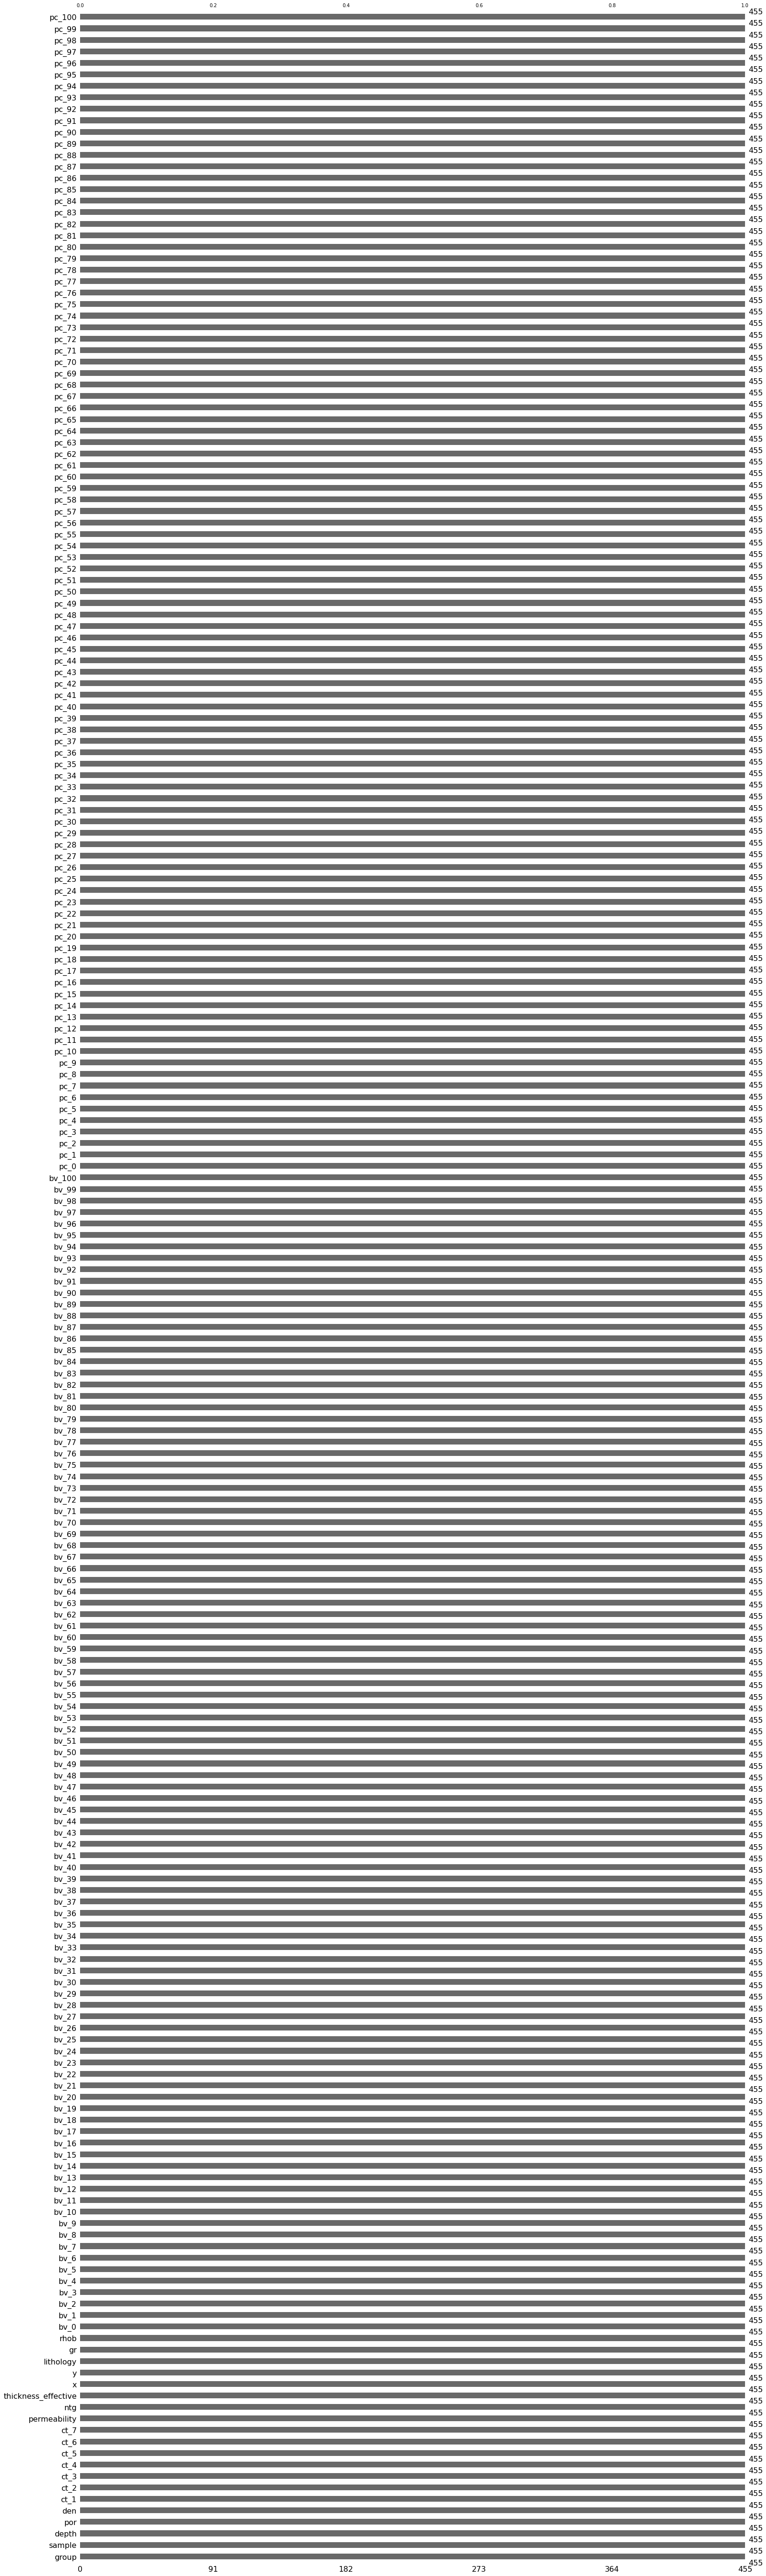

In [129]:
msno.bar(df_train)

In [130]:
X_train = df_train.loc[:, 'group':'rhob']

y_train = df_train.loc[:, 'bv_0' :]

lithology = df_train['lithology']

In [131]:
X_train

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,lithology,gr,rhob
0,3,52,1660.178974,18.556209,2.740942,1971.579998,2396.714551,2799.219912,1951.977330,2041.857394,2442.840273,2318.618853,6.425410,0.106890,5.658985,18985,5423,limestone,37.738168,2.664759
1,4,92,3890.779426,8.555400,2.834776,2513.180531,3001.782975,2348.160682,2414.636280,2798.706138,3035.549168,2729.578887,14.300516,0.718312,4.483886,16790,3644,shale,42.371106,2.760788
2,3,90,2287.441253,-0.169935,2.761468,2274.773580,1083.899155,2974.647775,2713.863889,2381.094609,2085.069195,2747.971468,12.825353,0.639979,6.349391,18985,5423,sandstone,42.931089,2.624635
3,3,49,2144.788740,28.192998,2.637605,1776.270868,2374.721334,2670.367528,2814.751969,2919.311685,2016.024319,2546.626337,13.320168,0.288901,3.819145,18985,5423,limestone,39.485022,2.634539
4,2,65,3754.453151,4.136069,2.900202,1787.771840,1893.016733,2818.411074,1542.522104,2246.952313,1943.089817,1561.393112,7.183351,0.500868,6.593625,16169,5288,siltstome,34.846060,2.459622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,5,51,2097.045676,14.781216,2.688458,2455.839335,2480.124636,2574.049871,2511.215039,2395.579990,2439.147140,2089.051532,41.015660,0.709441,7.313445,19850,3873,limestone,30.240244,2.562103
451,5,35,2078.198020,19.385152,2.684518,2044.566279,2052.309283,2343.335254,2529.277934,2360.570479,2256.546050,2663.343376,1.366440,0.554834,8.669671,19850,3873,limestone,14.771108,2.617332
452,2,68,3672.405920,26.585923,2.772035,2040.649000,2573.163502,1292.780567,2079.696767,2355.948265,2281.831720,2071.560649,3.371203,0.786869,4.971094,16169,5288,sandstone,41.162699,2.687207
453,5,6,2094.513127,16.977858,2.705836,2591.491630,2295.452470,2432.286576,2406.785838,2705.931007,2400.377198,2512.672454,16.081238,0.671111,7.022591,19850,3873,sandstone,37.093964,2.653836


**EDA**

In [132]:
X_train.describe()

,group,sample,depth,por,den,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,permeability,ntg,thickness_effective,x,y,gr,rhob
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,2.448352,50.305495,2745.421296,16.102537,2.750077,2376.476949,2395.344102,2414.676280,2434.162117,2406.252949,2425.921822,2386.838435,12.993038,0.488347,5.871009,18215.430769,4250.298901,37.499362,2.628022
std,1.711928,28.483573,725.532212,9.863184,0.081923,332.363936,360.760226,366.931061,359.797539,334.922285,351.113018,338.939730,14.532829,0.213568,1.562086,1513.154352,791.605903,9.413786,0.101322
min,0.000000,0.000000,1658.518146,-11.037018,2.551243,1115.162634,545.160119,1010.275447,1079.651893,1023.676112,1026.832876,1388.811369,0.297602,0.034014,-0.399415,16169.000000,3497.000000,-11.531345,2.248610
25%,1.000000,26.000000,2146.623200,8.904194,2.696166,2226.475393,2205.017158,2233.748775,2233.616265,2250.076649,2248.411432,2217.736576,4.280091,0.320130,5.080810,16790.000000,3644.000000,34.203722,2.571717
50%,2.000000,51.000000,2413.840472,15.241360,2.718682,2422.937099,2390.380522,2418.796350,2411.909007,2395.579990,2435.003358,2405.754498,7.806760,0.489435,6.054009,18985.000000,3873.000000,40.042615,2.646557
75%,4.000000,75.000000,3669.087377,24.620933,2.795985,2569.390144,2599.872816,2615.833409,2610.106429,2580.283855,2645.342209,2571.077633,15.946343,0.659713,6.735595,19850.000000,5288.000000,43.689289,2.705534
max,5.000000,99.000000,3982.323519,39.653924,3.026197,3546.752461,3337.252790,3605.182917,3731.672460,3528.797225,3321.997102,3479.413506,93.911558,0.913889,8.976372,20022.000000,5423.000000,51.735349,2.815049


Two-dimensional distribution of the corresponding target variables clustered along the "X" coordinate

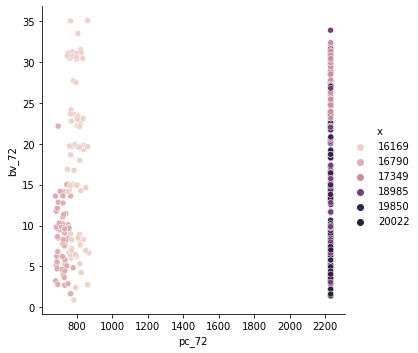

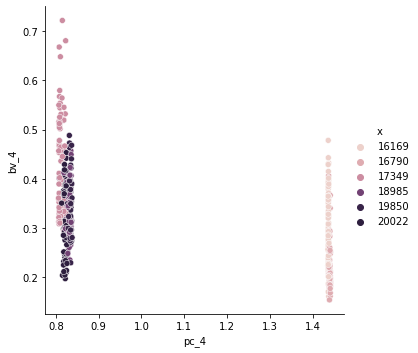

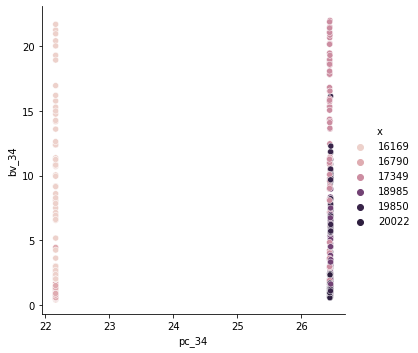

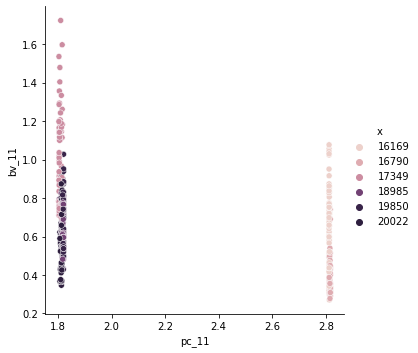

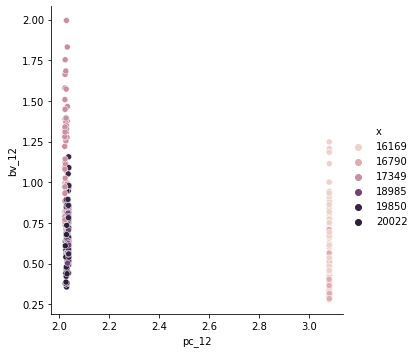

In [133]:
for idx in np.random.randint(0, 101, size=5):
  
  sns.relplot(data=df_train, 
              x=f'pc_{idx}',
              y=f'bv_{idx}',
              hue=df_train['x'])

Two-dimensional distribution of the corresponding target variables clustered by "lithology" column


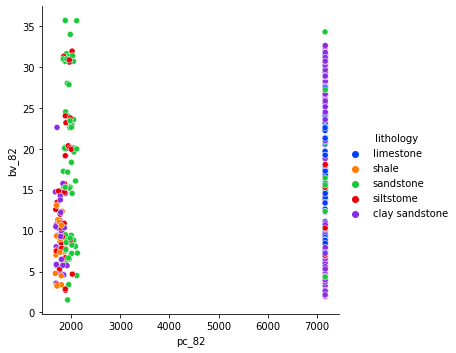

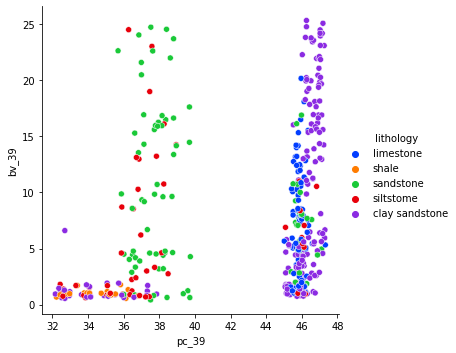

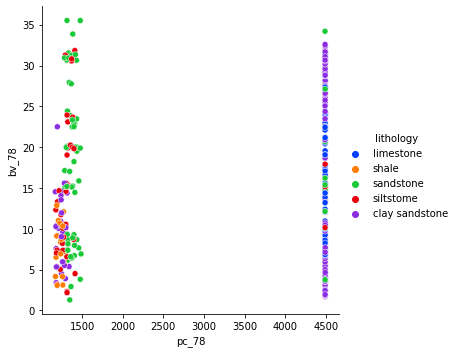

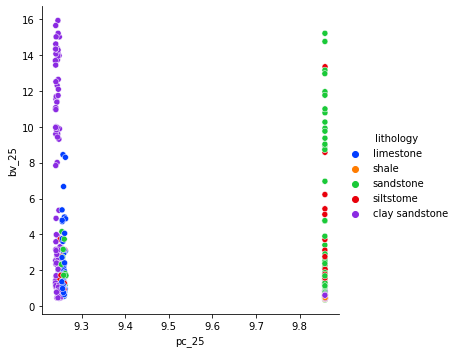

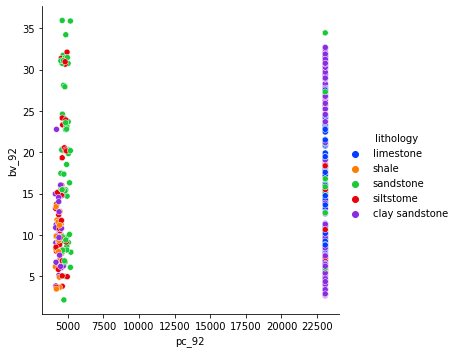

In [134]:
for idx in np.random.randint(0, 101, size=5):

  sns.set_palette('bright')
  sns.relplot(data=df_train, 
              x=f'pc_{idx}', 
              y=f'bv_{idx}', 
              hue=lithology)

Distribution of feature values

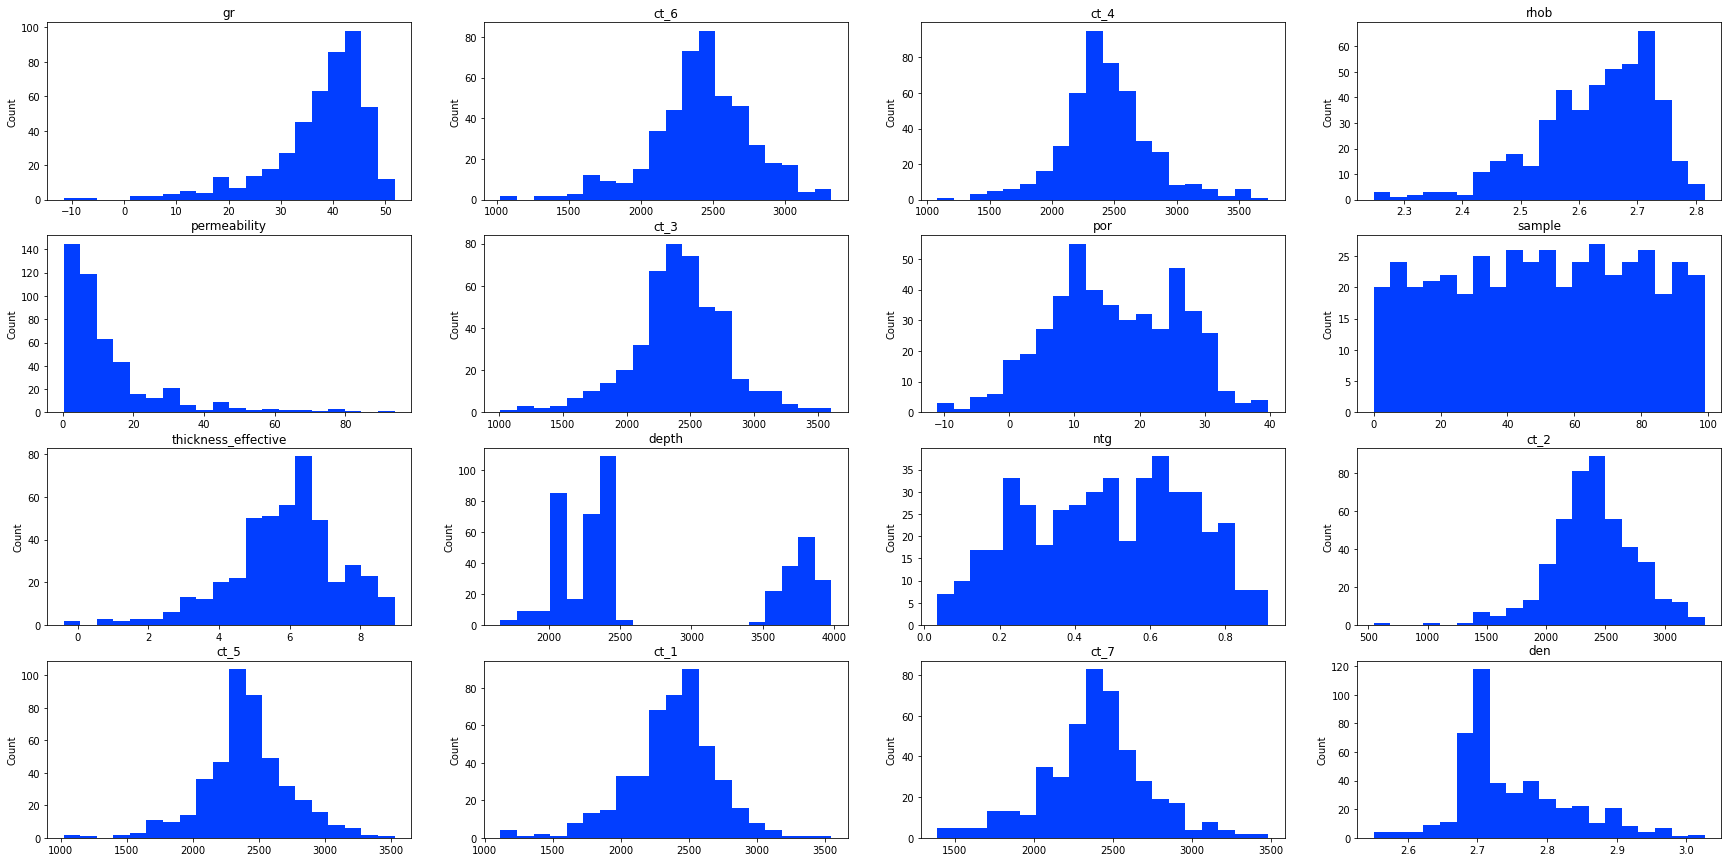

In [135]:
availible_columns = set(X_train.columns) - {'x', 'y', 'group', 'lithology'}

fig, ax = plt.subplots(nrows=4,
                       ncols=4,
                       figsize=(30,15))

for idx, feature in enumerate(availible_columns):

  ax[idx//4, idx%4].hist(X_train[feature], 
                         bins=20)

  ax[idx//4, idx%4].set_title(str(feature)) 

  ax[idx//4, idx%4].set_ylabel('Count')

Correlation matrix of features

[Text(0.5, 1.0, 'Correlation matrix of features')]

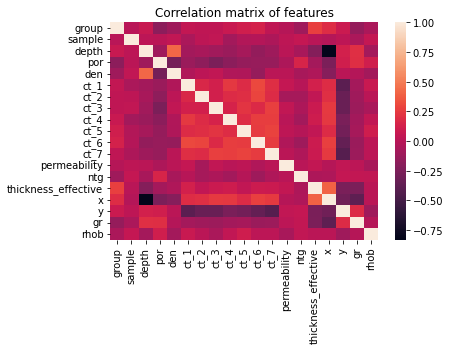

In [136]:
sns.heatmap(X_train.corr()).set(title='Correlation matrix of features')

**Preprocessing + Tuning the model's hyperparameters**

In [137]:
float_cols = set(X_train.columns) - {'group', 'sample', 'x', 'y', 'group', 'lithology'}

col_t = ColumnTransformer(transformers=[('le',OrdinalEncoder(),['lithology']),
                                        ('minmax', MinMaxScaler(), list(float_cols))],
                          remainder='passthrough'
                         )

In [138]:
def most_common(lst):
  
    counter = Counter()

    most_pop = lambda lst : max(set(lst), key=lst.count)

    values_lst = [list(item.values()) for item in lst]

    for item in values_lst:

      counter[tuple(item)] += 1

    for item in lst:

      if tuple(item.values()) == counter.most_common(1)[0][0]:

        return item


In [139]:
X_tmp = col_t.fit_transform(X_train)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7]}




In [146]:
params = []

for col in np.random.choice(y_train.columns, 2):

  cb = CatBoostRegressor(logging_level='Silent')

  tmp_result = cb.grid_search(grid,X=X_tmp,y=y_train.loc[:,col])

  params.append(tmp_result['params'])

best_params = most_common(params)

best_params

0:	loss: 1.4090188	best: 1.4090188 (0)	total: 2.71s	remaining: 1m 23s
1:	loss: 1.3376324	best: 1.3376324 (1)	total: 3.85s	remaining: 57.8s
2:	loss: 1.4630441	best: 1.3376324 (1)	total: 5.85s	remaining: 56.6s
3:	loss: 1.4120893	best: 1.3376324 (1)	total: 6.92s	remaining: 48.4s
4:	loss: 1.5047050	best: 1.3376324 (1)	total: 7.95s	remaining: 42.9s
5:	loss: 1.4212020	best: 1.3376324 (1)	total: 8.97s	remaining: 38.9s
6:	loss: 1.5121304	best: 1.3376324 (1)	total: 9.99s	remaining: 35.7s
7:	loss: 1.4434617	best: 1.3376324 (1)	total: 11s	remaining: 33s
8:	loss: 2.0005766	best: 1.3376324 (1)	total: 13.7s	remaining: 35s
9:	loss: 2.2612485	best: 1.3376324 (1)	total: 16.8s	remaining: 37s
10:	loss: 2.1037706	best: 1.3376324 (1)	total: 19.7s	remaining: 37.7s
11:	loss: 2.4941786	best: 1.3376324 (1)	total: 22.3s	remaining: 37.2s
12:	loss: 2.2000448	best: 1.3376324 (1)	total: 25s	remaining: 36.5s
13:	loss: 2.4411250	best: 1.3376324 (1)	total: 27.6s	remaining: 35.5s
14:	loss: 2.1631329	best: 1.3376324 (1)

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [147]:
baseline_model = Pipeline([('Preprocess', col_t),
                           ('lr', LinearRegression())])

cb_model = Pipeline([('Preprocess', col_t),
                                ('boost', CatBoostRegressor(**best_params, verbose=False))])

**Cross validation**

In [149]:
def cross_validate_check(X_train, y_train, pipe_model):

  losses = defaultdict(dict)

  for target in y_train.columns:

    tmp_model = deepcopy(pipe_model)

    score = cross_validate(tmp_model, 
                           X_train, 
                           y_train[target].values, 
                           cv=5, 
                           scoring = ['r2','neg_mean_absolute_percentage_error'])

    losses[target]['r2'] = abs(score['test_r2'].mean())
    
    losses[target]['MAPE'] = abs(score['test_neg_mean_absolute_percentage_error'].mean())

  return losses





In [150]:
baseline_scores = cross_validate_check(X_train, 
                                       y_train, 
                                       baseline_model)

In [158]:
baseline_scores

defaultdict(dict,
            {'bv_0': {'r2': 0.041540910868482994,
              'MAPE': 3.555530936714201e-15},
             'bv_1': {'r2': 0.09285698339776165, 'MAPE': 0.6973191196268598},
             'bv_2': {'r2': 0.09603411129920932, 'MAPE': 0.31791157803761416},
             'bv_3': {'r2': 0.4386198714370925, 'MAPE': 0.16122328005950026},
             'bv_4': {'r2': 0.46791845934176096, 'MAPE': 0.15900834354488505},
             'bv_5': {'r2': 0.4919117499735018, 'MAPE': 0.16642193502672345},
             'bv_6': {'r2': 0.4853933153125537, 'MAPE': 0.16146096476576546},
             'bv_7': {'r2': 0.4883929031796388, 'MAPE': 0.1706766284899603},
             'bv_8': {'r2': 0.5027623595081145, 'MAPE': 0.17239094975395627},
             'bv_9': {'r2': 0.5114481501924923, 'MAPE': 0.17826695904493756},
             'bv_10': {'r2': 0.532080683663097, 'MAPE': 0.18133453293176358},
             'bv_11': {'r2': 0.5521658944988828, 'MAPE': 0.18252330192675784},
             'bv_12': {'r2

In [151]:
boosting_scores = cross_validate_check(X_train, 
                                       y_train, 
                                       cb_model)

In [152]:
boosting_scores

defaultdict(dict,
            {'bv_0': {'r2': 0.3754568150270442, 'MAPE': 2.511144930858515e-15},
             'bv_1': {'r2': 0.3492774214908806, 'MAPE': 0.46681867394877585},
             'bv_2': {'r2': 0.23912594251337388, 'MAPE': 0.2781134700210331},
             'bv_3': {'r2': 0.4193941253628747, 'MAPE': 0.15868564083293976},
             'bv_4': {'r2': 0.44238381924705966, 'MAPE': 0.1576206213010606},
             'bv_5': {'r2': 0.46605668374337084, 'MAPE': 0.16500556234271088},
             'bv_6': {'r2': 0.4633556333578346, 'MAPE': 0.1566879828331193},
             'bv_7': {'r2': 0.449144082436827, 'MAPE': 0.16847782397970434},
             'bv_8': {'r2': 0.49174809669046926, 'MAPE': 0.16428488069746908},
             'bv_9': {'r2': 0.49946021318463557, 'MAPE': 0.16986297108177117},
             'bv_10': {'r2': 0.5360169369394188, 'MAPE': 0.17128174436344673},
             'bv_11': {'r2': 0.5371682098039692, 'MAPE': 0.17725693090274292},
             'bv_12': {'r2': 0.5187236098

In [153]:
count_features = 2

random_targets = np.random.choice([num for num in range(101)], count_features)

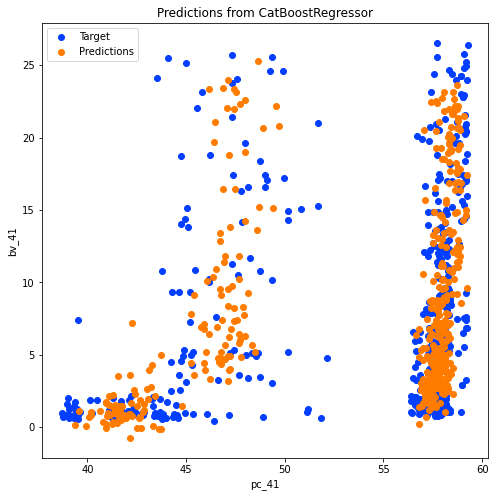

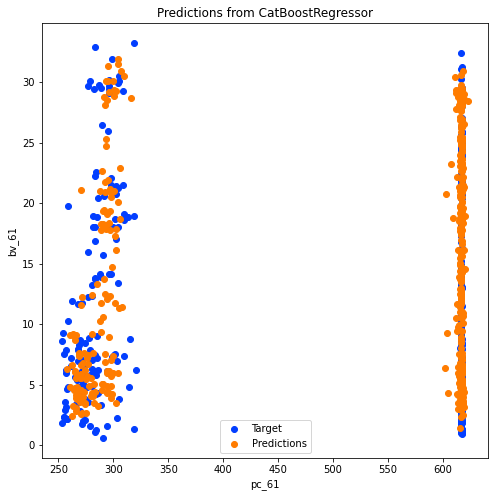

In [154]:
model_bv = deepcopy(cb_model)

model_pc = deepcopy(cb_model)

for num in random_targets:

  fig, ax = plt.subplots(figsize=(8,8))

  bv_preds = cross_val_predict(model_bv, 
                               X_train, 
                               y_train.loc[:,f'bv_{num}'], 
                               cv=5)

  pc_preds = cross_val_predict(model_pc, 
                               X_train, 
                               y_train.loc[:,f'pc_{num}'], 
                               cv=5)

  ax.scatter(y_train[f'pc_{num}'], 
             y_train[f'bv_{num}'], 
             label='y_True')

  ax.scatter(pc_preds, 
             bv_preds, 
             label='predictions')

  ax.legend(['Target','Predictions'])

  ax.set_title('Predictions from CatBoostRegressor')

  ax.set_xlabel(f'pc_{num}')

  ax.set_ylabel(f'bv_{num}')

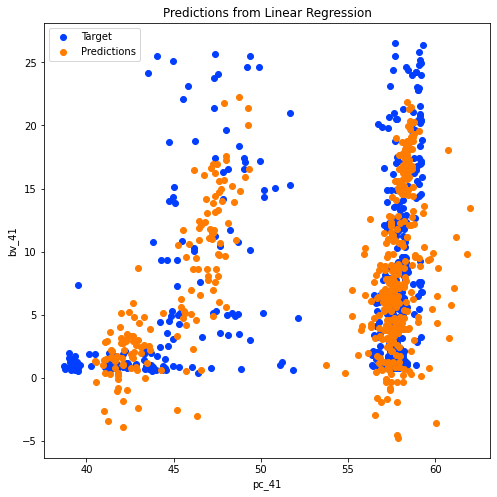

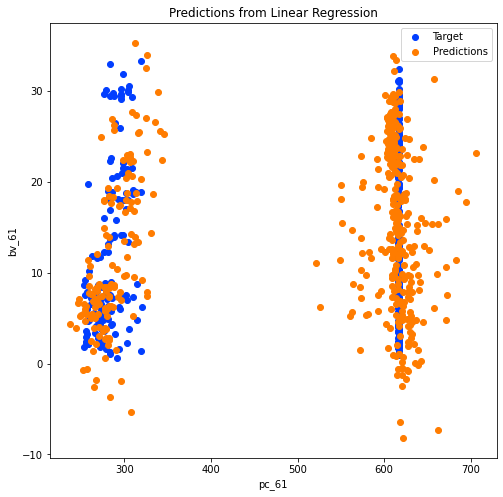

In [155]:
model_bv = deepcopy(baseline_model)

model_pc = deepcopy(baseline_model)

for num in random_targets:

  fig, ax = plt.subplots(figsize=(8,8))

  bv_preds = cross_val_predict(model_bv, 
                               X_train, 
                               y_train.loc[:,f'bv_{num}'], 
                               cv=5)

  pc_preds = cross_val_predict(model_pc, 
                               X_train, 
                               y_train.loc[:,f'pc_{num}'], 
                               cv=5)

  ax.scatter(y_train[f'pc_{num}'], 
             y_train[f'bv_{num}'], 
             label='y_True')

  ax.scatter(pc_preds, 
             bv_preds, 
             label='predictions')

  ax.legend(['Target','Predictions'])

  ax.set_title('Predictions from Linear Regression')

  ax.set_xlabel(f'pc_{num}')

  ax.set_ylabel(f'bv_{num}')

**Train the models**

In [156]:
models = []

for col in y_train.columns:

  cb_model = deepcopy(cb_model)

  cb_model.fit(X_train,
               y_train.loc[:,col])

  models.append(cb_model)

In [157]:
preds_test_sample = defaultdict(np.array)

for idx,model in enumerate(models):

  preds_test_sample[y_train.columns[idx]] = model.predict(df_test)

**After an intelligence analysis of the data, I carried out data preprocessing using MinMaxScaler for continuous values and OrderEncoder for discrete ones. My basic model is linear regression. And the main model catboost with selected hyperparameters. One of the improvements, I considered it possible to bagging over boosting that have parameters on which these models are trained better for most target values, in order to reduce the variance and non-change of the bias of the predicted values.**